# A Data Analysis using Stackoverflow’s 2019 - 2023 Annual Developer Survey

## Each stage of the CRISP-DM process

1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling
5. Evaluate the Results


# Business Understanding

In this notebook, I will be exploring the 2019 - 2023 Stack Overflow results in order to understand revelant programming languages and the shift in programming language usage with information given by professional developers.

There will be three questions I will seek to answer in order to get this information:

1. What programming languages in the last 5 years are most widely used and how have they changed in usage across those years?
2. What are some of the fastest growing and declining programming languages used by developers in the past 5 years?
3. What new programming languages have emerged and how have they grown in usage?

# Data Understanding

In order to gain some understanding of the data. I have to do these steps:
* Handle categorical and missing data
* Analyze, Model, and Visualize

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

## Data Cleaning and Modeling Functions

### Remove Null Rows

In [138]:
def remove_null_rows(percent, df):
    
    min_count = int(((100-percent)/100)*df.shape[1] + 1)
    
    # drop rows that don't meet min_count threshold
    df = df.dropna(axis=0, thresh = min_count)
    
    return df

### Remove Trailing and Leading Whitespace

In [ ]:
def strip_df(df):
    return df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### Count Number of Languages Wroked With Each Survey

In [139]:
def get_count_languages_used(df):
    
    df = df.copy()
    
    # different terms for languages programmers have worked with
    language_worked = ['LanguageHaveWorkedWith', 'LanguageWorkedWith', 'HaveWorkedLanguage']
    
    for used_key in language_worked:
        
        try:
            
            #get response id and column and uniformily name it across all survey data
            response_id = df.iloc[:,0]
            df['ResponseId'] = response_id
            
            #get the year of the survey data and store value
            year = df['Year'].loc[0]
            
            #lower case all languages
            df[used_key] = df[used_key].str.lower()
            
            #drop null language rows
            df = df.dropna(subset = [used_key])
            
            #store survey data
            orginal = df
            
            #create expanded languages dataframe
            df = df[used_key].str.split(';', expand = True)
            
            #remove all trailing and leading white space from languages
            df = strip_df(df)
            
            #replace all languages with shell in it will the name shell
            df = df.replace(to_replace='.*shell.*', value='shell', regex=True)
            
            #df.columns = ['Language' + str(col) for col in df.columns]
            
            #add the Response IDs back into dataframe
            df = pd.concat([orginal['ResponseId'],df], axis = 1)
            
            # get the counts of each language used
            df = pd.melt(df, id_vars = ['ResponseId'], value_vars = df.columns[1:].values)
            df = df.groupby(['ResponseId','value']).count().reset_index()['value'].value_counts()
            df = df.reset_index().rename(columns = {'index': 'Language', 'value': 'count'})
            
            #add the year back to the new skills dataframe
            df['Year'] = year
            
            break
        
        except KeyError:
            continue
    
    return df


## Load Data

In [297]:
start_year = 2019
end_year = 2023

survey_dict = {}

for year in range(start_year, end_year + 1, 1):
    
    #read in data and store in dictionary
    survey_dict[f'survey_{year}'] = pd.read_csv(f'./{year}/survey_results_public.csv')
    
    #add a year column to each survey_result data
    survey_dict[f'survey_{year}']['Year'] = year
    
    # remove rows that have 90% missing data for that row
    survey_dict[f'survey_{year}'] = remove_null_rows(90, survey_dict[f'survey_{year}']).reset_index(drop = True)

# Model Data

In [141]:
language = pd.DataFrame()
lang_dict = {}

for key, df in survey_dict.items():
    lang_dict[key] = get_count_languages_used(df)
    language = pd.concat([language, lang_dict[key]])
    
    

## Pivot Data

In [459]:
pivot_lang = language.pivot_table(index = ['Year'], columns = ['Language'])
pivot_lang.columns = pivot_lang.columns.droplevel(level = 0)
pivot_lang.fillna(0,inplace = True)

In [460]:
lang_cnts = pivot_lang.sum().reset_index().rename(columns = {0:'count'}).sort_values(by = 'count', ascending = False).reset_index(drop = True)
top_8_lang = lang_cnts[:8]
top_8_lang

,Language,count
0,javascript,253781.0
1,html/css,223444.0
2,sql,195542.0
3,python,178834.0
4,java,138554.0
5,shell,136676.0
6,typescript,116802.0
7,c#,112198.0


## Pivoted Scaled data

In [461]:
# scale the data so yearly survey respondent count doesn't distort lang count
pivot_lang_adj = pivot_lang.div(pivot_lang.sum(axis = 1), axis = 0) * 1000

top_8_lang_years = pivot_lang_adj.loc[:,top_8_lang.Language]
top_8_lang_years

Language,javascript,html/css,sql,python,java,shell,typescript,c#
Year,,,,,,,,
2019,134.434342,125.914575,107.930670,82.730048,81.535964,72.623466,42.049466,61.513490
2020,134.796739,125.626727,109.071402,87.800864,80.116943,65.901862,50.617353,62.641491
2021,122.314868,105.588361,88.642729,90.827127,66.563648,61.179118,56.855974,52.462070
2022,127.801031,107.712587,96.663942,93.986400,65.064544,68.262184,68.110833,54.714868
2023,121.110870,100.860870,92.658696,93.821739,58.167391,74.121739,74.002174,52.593478


## Unpivoted Scaled Data

In [462]:
unpivot_lang_adj = pd.melt(pivot_lang_adj.reset_index(),
              id_vars= 'Year',
              var_name = 'Language',
              value_name= 'Number of Languages per 1000 Responses')
unpivot_lang_adj

,Year,Language,Number of Languages per 1000 Responses
0,2019,ada,0.000000
1,2020,ada,0.000000
2,2021,ada,0.000000
3,2022,ada,0.000000
4,2023,ada,1.471739
...,...,...,...
260,2019,zig,0.000000
261,2020,zig,0.000000
262,2021,zig,0.000000
263,2022,zig,0.000000


## New Languages Modeling

In [502]:
new_lang_dict = { 'Languages': [], 'year': []}

for i, (key, df) in enumerate(lang_dict.items()):
    
    current_langs = df.Language.values.tolist()
    
    
    if i == 0:
        compare_langs = current_langs
        continue
    
    
    new_langs = np.setdiff1d(current_langs, compare_langs).tolist()
    year = [df.Year[0]] * len(new_langs)
    compare_langs += current_langs
    compare_langs = list(set(compare_langs))
    new_lang_dict['Languages'] += new_langs
    new_lang_dict['year'] += year
    

new_lang = pd.DataFrame(new_lang_dict)
new_lang_pivot = pivot_lang_adj.loc[:,new_lang.Languages.values].replace(0, np.nan)
new_lang_pivot = new_lang_pivot.drop('node.js', axis = 1)
top_8_new_langs = new_lang_pivot.sum().sort_values(ascending = False)[:8]
max_8_new_langs = new_lang_pivot.max()[new_lang_pivot.count() > 1].sort_values(ascending = False)[:8]

## Model Languages by Growth

In [467]:
#removing zero count survey results from data, assuming the survey field wasn't present
pivot_start = pivot_lang_adj.loc[start_year]
pivot_end = pivot_lang_adj.loc[end_year]

#remove langs that with no survey results for that year
pivot_start = pivot_start.loc[pivot_start.values > 0]
pivot_end = pivot_end.loc[pivot_end.values > 0]

# get percent growth and overall growth
growth_use = (pivot_end - pivot_start).sort_values(ascending = False).dropna()
percent_growth_use = ((pivot_end - pivot_start)/pivot_start).sort_values(ascending = False).dropna()

# Plot and Analyze Data

## Question 1: What programming languages in the last 5 years are most widely used and how have they changed in usage across those years?

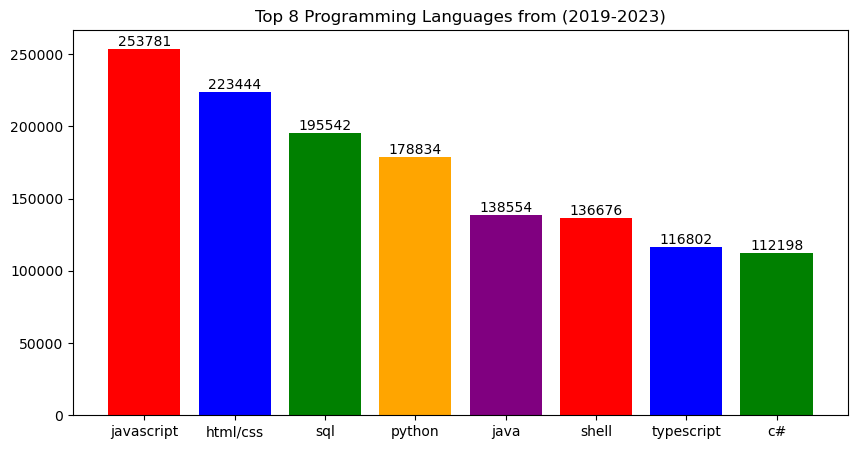

In [464]:
df = top_8_lang.sort_values(by = 'count',ascending = False)

x = df['Language']
y = df['count']

colors = ['red', 'blue', 'green', 'orange', 'purple']
fig, ax = plt.subplots(figsize = (10,5))
ax.bar(x, y, color = colors)

for i in ax.containers:
    ax.bar_label(i)

plt.title(f'Top 8 Programming Languages from ({start_year}-{end_year})')
plt.show()

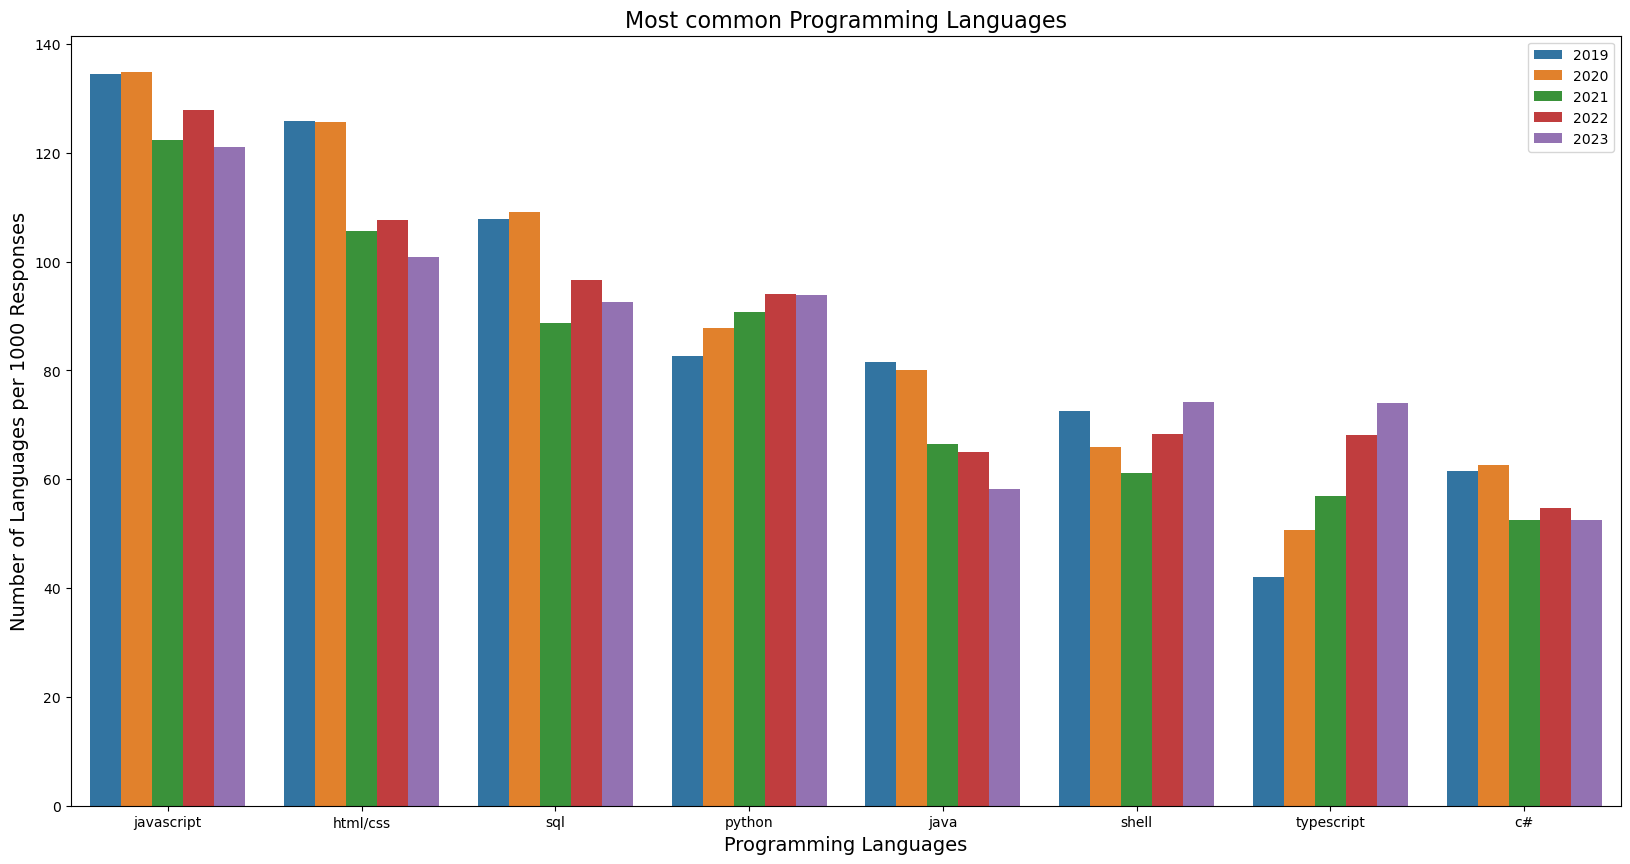

In [478]:
plt.figure(figsize=(20,10))
sns.barplot(x = 'Language', 
            y = 'Number of Languages per 1000 Responses',
            hue = 'Year',
            data = unpivot_lang_adj[unpivot_lang_adj.Language.isin(top_8_lang.Language)].set_index('Language').loc[top_8_lang.Language.tolist()].reset_index())

plt.xlabel("Programming Languages", fontsize = 14)
plt.ylabel("Number of Languages per 1000 Responses", fontsize = 14)
plt.legend(title_fontsize='40')
plt.title('Most common Programming Languages', size = 16)
plt.show()

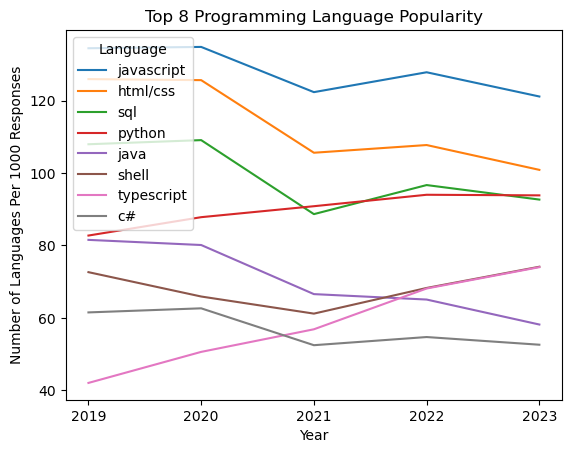

In [466]:
ax = top_8_lang_years.plot(kind='line')
ax.set_xticks(top_8_lang_years.index.values)
plt.title('Top 8 Programming Language Popularity')
plt.xlabel('Year')
plt.ylabel('Number of Languages Per 1000 Responses')
plt.show()

## Evaluate the Results

* The top 8 program languages in order over the last 5 years were JavaScript, HTML/CSS, SQL, Python, Java, some form of shell language, TypeScript, and C#. 

* Over the course of 5 years, it appears all the languages are trending downward and leveling off as they approach 2023. However, Python and TypeScript have seen growth in popularity recently.

* Although, still popular in usage it is interesting to see such a downward trend of some of the most widely used programming languages.


## Question 2: What are some of the fastest growing and declining programming languages used by developers in the past 5 years?

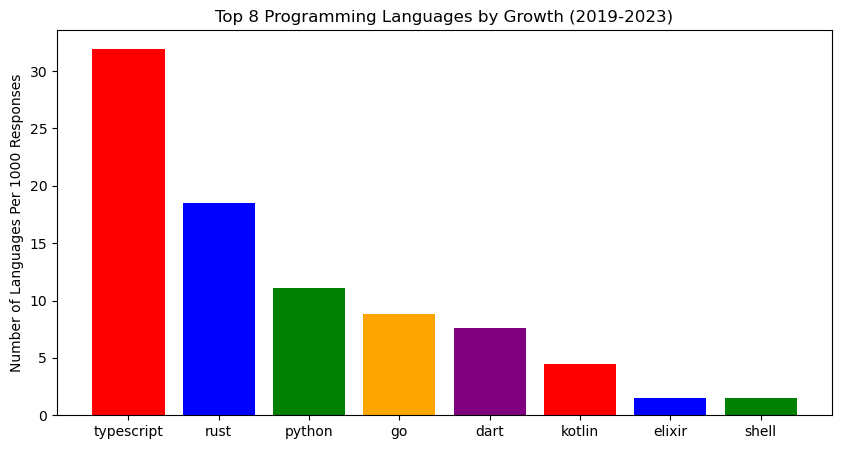

In [291]:
df = growth_use
show_num = 8

x = df.index[:show_num]
y = df.values[:show_num]

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(x, y, color = colors)

#for i in ax.containers:
    #ax.bar_label(i)

plt.title(f'Top {show_num} Programming Languages by Growth ({start_year}-{end_year})')
plt.ylabel('Number of Languages Per 1000 Responses')
plt.show()

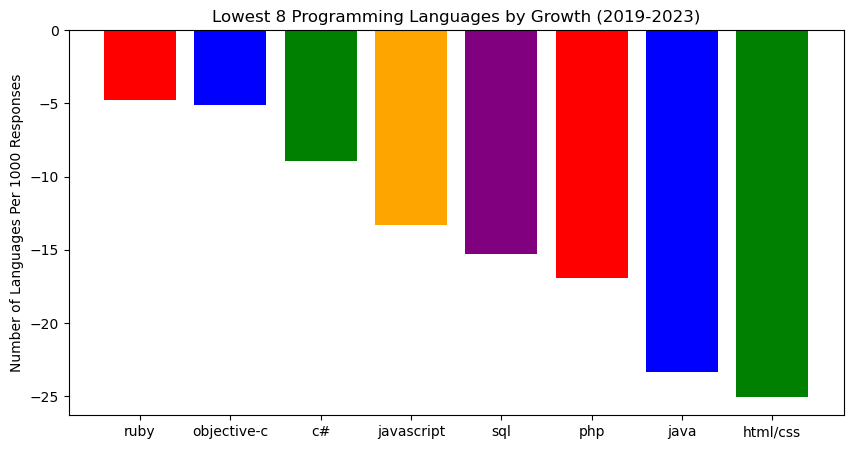

In [316]:
df = growth_use
show_num = 8

x = df.index[-show_num:]
y = df.values[-show_num:]

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(x, y, color = colors)

#for i in ax.containers:
    #ax.bar_label(i)

plt.title(f'Lowest {show_num} Programming Languages by Growth ({start_year}-{end_year})')
plt.ylabel('Number of Languages Per 1000 Responses')
plt.show()

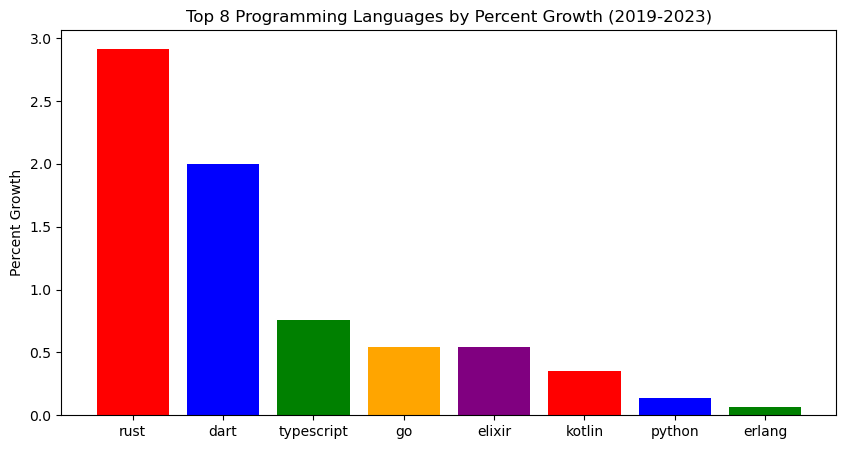

In [315]:
df = percent_growth_use
show_num = 8

x = df.index[:show_num]
y = df.values[:show_num]

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(x, y, color = colors)

#for i in ax.containers
    #ax.bar_label(i)

plt.title(f'Top {show_num} Programming Languages by Percent Growth ({start_year}-{end_year})')
plt.ylabel('Percent Growth')
plt.show()

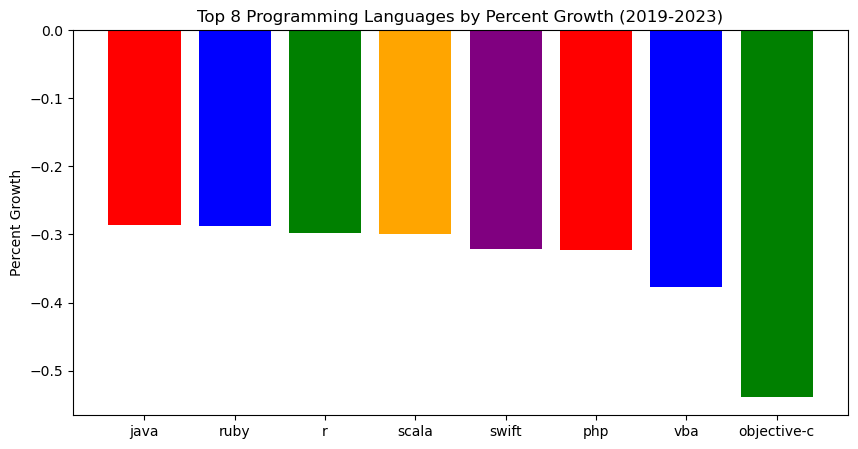

In [294]:
df = percent_growth_use
show_num = 8

x = df.index[-show_num:]
y = df.values[-show_num:]

fig, ax = plt.subplots(figsize = (10,5))
ax.bar(x, y, color = colors)

#for i in ax.containers:
    #ax.bar_label(i)

plt.title(f'Top {show_num} Programming Languages by Percent Growth ({start_year}-{end_year})')
plt.ylabel('Percent Growth')
plt.show()

## Evaluate the Results

* Typescript, Rust, Python, and Go were among the largest growing programming languages and HTML/CSS and Java substantially declined in the last 5 years.
* An interesting observance is the increase of Typescript and the decline of JavaScript. Typescript is a language that builds on JavaScript which could have contributed partially to the decline.
* Rust, Typescript, Dart, and Go were among the highest in percent growth over the last 5 years showing a trajectory of more use in the space in the future. While VBA, PHP, and Objective-C showed the largest percent decrease over 5 years showing possible diminishing relevancy in the workforce.

## 3. What new programming languages have emerged and how have they grown in usage?

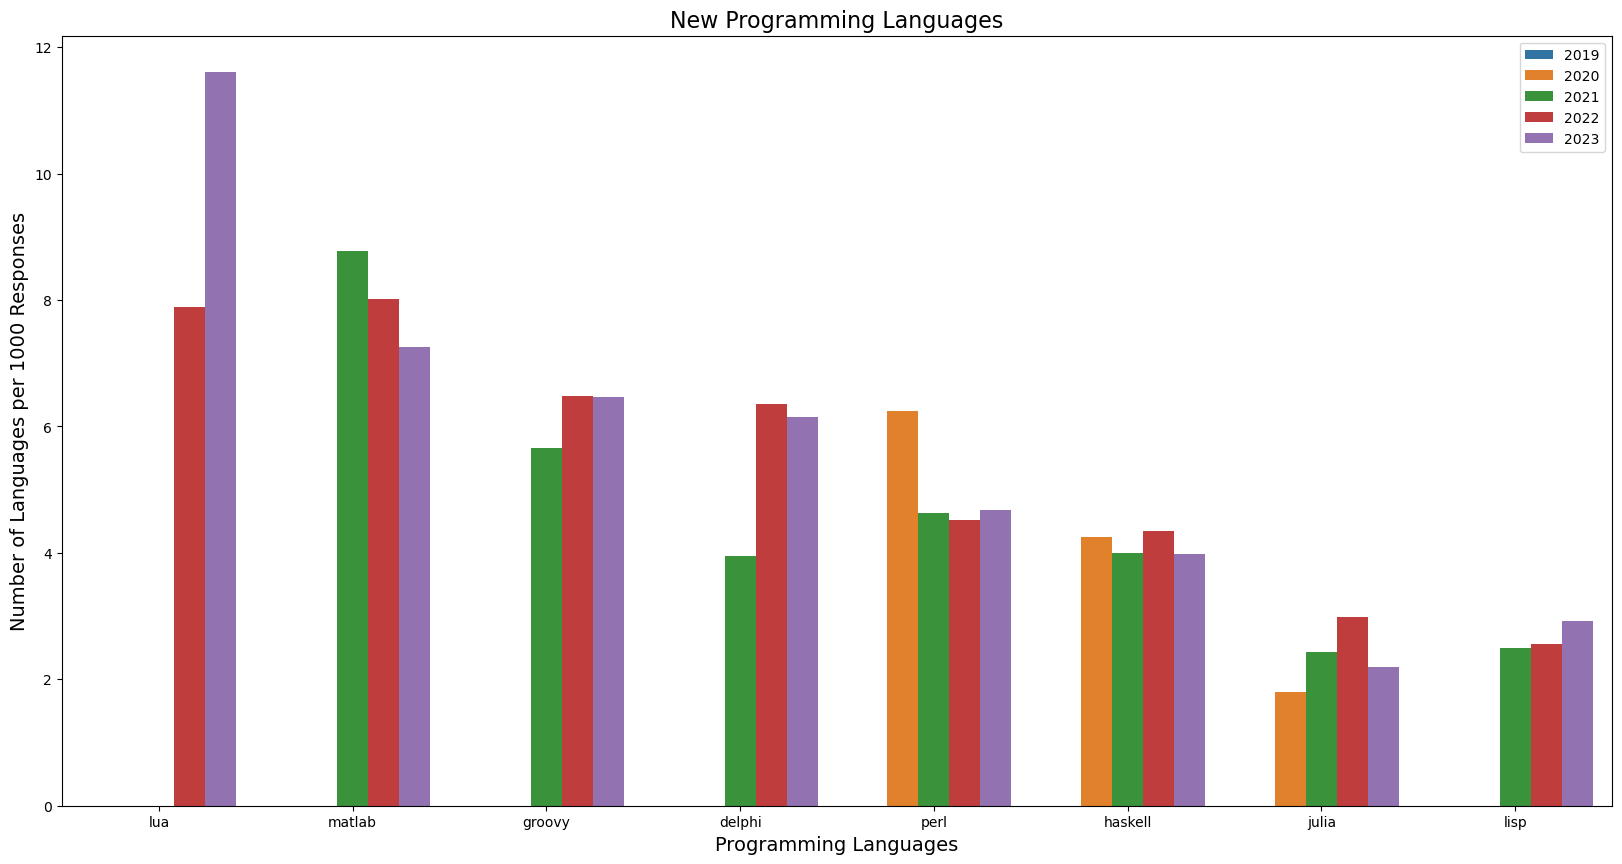

In [505]:
plt.figure(figsize=(20,10))
sns.barplot(x = 'Language', 
            y = 'Number of Languages per 1000 Responses',
            hue = 'Year',
            data = unpivot_lang_adj[unpivot_lang_adj.Language.isin(max_8_new_langs.index)].set_index('Language').loc[max_8_new_langs.index.tolist()].reset_index())
plt.xlabel("Programming Languages", fontsize = 14)
plt.ylabel("Number of Languages per 1000 Responses", fontsize = 14)
plt.legend(title_fontsize='40')
plt.title('New Programming Languages', size = 16)
plt.show()

## Evaluate the Results

* After seeing the trends of programming language growth that have been around over the last 5 years, I wanted to observe which programming languages that were new to the survey data over the last 5 years and how they are growing in usage among developers.
* Lua, Matlab, Groovy, and Perl were the programming languages that newly appeared in survey results between 2020–2023. The only software that showed substantial growth was Lua from 2022–2023. However, it is too early to tell if this trend is noteworthy with only two data points. Delphi saw moderate growth and is trending slightly upward in usage.